<a href="https://colab.research.google.com/github/polinaproskura/NLP_ensembles/blob/main/BERT_training_weak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
! pip install datasets
! pip install transformers
! pip install accelerate -U
clear_output()

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, set_seed
from sklearn.metrics import accuracy_score
from datasets import load_dataset
import numpy as np

In [ ]:
set_seed(42)
imdb = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_imdb = imdb.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch import nn
import copy
oldModuleList = model.distilbert.transformer.layer
newModuleList = nn.ModuleList(oldModuleList[:1])

copyOfModel = copy.deepcopy(model)
copyOfModel.distilbert.transformer.layer = newModuleList

model = copyOfModel

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    seed=43,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.542200
1000,0.354000
1500,0.313200
2000,0.276300
2500,0.258900
3000,0.248100
3500,0.201500
4000,0.206600
4500,0.195200
5000,0.177500


TrainOutput(global_step=7815, training_loss=0.2301060213466066, metrics={'train_runtime': 1065.6976, 'train_samples_per_second': 117.294, 'train_steps_per_second': 7.333, 'total_flos': 2921092499836416.0, 'train_loss': 0.2301060213466066, 'epoch': 5.0})

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
! cp -r results/checkpoint-7500/ gdrive/MyDrive/results_bert_weak_3

In [ ]:
weak_seeds = [123, 42, 43]

def load_trainer_weak(number, seed):
    model = AutoModelForSequenceClassification.from_pretrained("gdrive/MyDrive/results_bert_weak_" + str(number) + "/")
    oldModuleList = model.distilbert.transformer.layer
    newModuleList = nn.ModuleList(oldModuleList[:1])

    copyOfModel = copy.deepcopy(model)
    copyOfModel.distilbert.transformer.layer = newModuleList

    training_args = TrainingArguments(
        output_dir="./results",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        seed=seed,
    )

    trainer = Trainer(
        model=copyOfModel,
        args=training_args,
        train_dataset=tokenized_imdb["train"],
        eval_dataset=tokenized_imdb["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
    )
    return trainer, copyOfModel

def load_trainer(number, seed):
    model = AutoModelForSequenceClassification.from_pretrained("gdrive/MyDrive/results_bert_" + str(number) + "/")
    training_args = TrainingArguments(
        output_dir="./results",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        seed=seed,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_imdb["train"],
        eval_dataset=tokenized_imdb["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
    )
    return trainer, model


In [ ]:
models = []
trainers = []
for i in range(1, 6):
    trainer, model = load_trainer(i, 123)
    models.append(model)
    trainers.append(trainer)

weak_models = []
weak_trainers = []
for i in range(1, 4):
    trainer, model = load_trainer_weak(i, 123)
    weak_models.append(model)
    weak_trainers.append(trainer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at gdrive/MyDrive/results_bert_weak_1/ and are newly initialized: ['distilbert.transformer.layer.1.attention.v_lin.weight', 'distilbert.transformer.layer.2.sa_layer_norm.bias', 'distilbert.transformer.layer.1.output_layer_norm.weight', 'distilbert.transformer.layer.5.output_layer_norm.bias', 'distilbert.transformer.layer.3.output_layer_norm.weight', 'distilbert.transformer.layer.1.attention.out_lin.bias', 'distilbert.transformer.layer.1.sa_layer_norm.bias', 'distilbert.transformer.layer.5.ffn.lin2.bias', 'distilbert.transformer.layer.3.attention.v_lin.bias', 'distilbert.transformer.layer.5.output_layer_norm.weight', 'distilbert.transformer.layer.4.attention.q_lin.weight', 'distilbert.transformer.layer.5.ffn.lin1.bias', 'distilbert.transformer.layer.5.attention.q_lin.bias', 'distilbert.transformer.layer.5.ffn.lin2.weight', 'distilbert.transformer.layer.1.attention.q_lin.weight', 'distilber

In [ ]:
dataset = tokenized_imdb["test"].train_test_split(test_size=0.5)
train, val, test = tokenized_imdb["train"], dataset['train'], dataset['test']

In [ ]:
weak_single_predictions = []
for trainer in weak_trainers:
    predictions = trainer.predict(test)
    weak_single_predictions.append(predictions)

In [ ]:
true_labels = np.genfromtxt("./gdrive/MyDrive/ens_predictions/true_labels.csv", delimiter=',')
single_predictions = []
for i in range(5):
    single_predictions.append(np.genfromtxt("./gdrive/MyDrive/ens_predictions/prediction_" + str(i + 1) + ".csv", delimiter=','))
single_predictions = np.array(single_predictions)

In [ ]:
weak_single_predictions[0].predictions, weak_single_predictions[0].label_ids

(array([[ 4.570135 , -5.1453104],
        [ 3.57587  , -4.1583714],
        [ 4.437607 , -5.0070267],
        ...,
        [ 2.5889924, -2.9951382],
        [ 4.704106 , -5.2680125],
        [-3.492142 ,  3.80211  ]], dtype=float32),
 array([0, 0, 0, ..., 1, 1, 1]))

In [ ]:
from sklearn.metrics import accuracy_score
for el in weak_single_predictions:
    print(accuracy_score(np.argmax(el.predictions, axis=1), el.label_ids))

0.84696
0.83656
0.87784


In [ ]:
for el in single_predictions:
    print(accuracy_score(np.argmax(el.predictions, axis=1), el.label_ids))

In [ ]:
def weighted_prediction(single_predictions, weights):
    print(single_predictions[0].shape)
    print(single_predictions[1].shape)
    weights = weights / weights.sum()
    return np.vstack((np.dot(weights, np.array(single_predictions)[:, :, 0]), np.dot(weights, np.array(single_predictions)[:, :, 1]))).T

In [ ]:
true_labels

array([1., 0., 0., ..., 0., 1., 0.])

In [ ]:
for el in weak_single_predictions:
    weights = np.array([0.5, 0.5])
    preds = np.array([single_predictions[2], el.predictions])
    print(preds.shape)
    weighted_predictions = weighted_prediction(preds, weights)
    print(accuracy_score(np.argmax(weighted_predictions, axis=1), true_labels))

(2, 12500, 2)
(12500, 2)
(12500, 2)
0.5828
(2, 12500, 2)
(12500, 2)
(12500, 2)
0.53072
(2, 12500, 2)
(12500, 2)
(12500, 2)
0.81064


In [ ]:
for i in range(3):
    np.savetxt("./gdrive/MyDrive/ens_predictions/weak_prediction_" + str(i + 1) + ".csv", weak_single_predictions[i].predictions, delimiter=",")

In [ ]:
def accuracy_rejection(N, step, probs, true_labels, predicted_labels):
    idx = np.argsort(probs)[::-1]
    r_rate = [0]
    r_accuracy = [accuracy_score(true_labels, predicted_labels)]
    for i in range(step, N, step):
        idx = idx[:(N - i)]
        r_rate.append(i / N)
        r_accuracy.append(accuracy_score(true_labels[idx], predicted_labels[idx]))
    return r_rate, r_accuracy

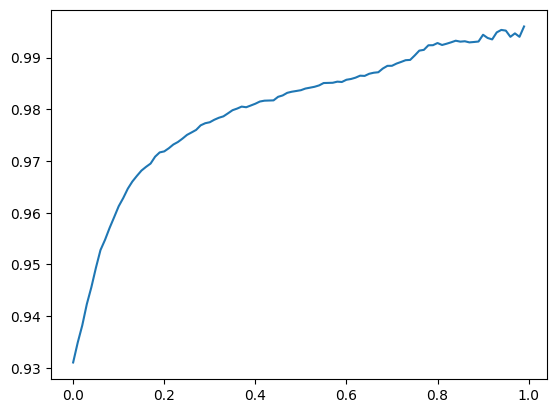

In [ ]:
import matplotlib.pyplot as plt
mx_val = max(predictions.predictions.ravel().max(), np.abs(predictions.predictions.ravel().min()))
predicted_labels = np.argmax(predictions.predictions, axis=1)
sigmoid = predictions.predictions# / mx_val#1 / (1 + np.exp(predictions.predictions))
x, y = accuracy_rejection(N=len(sigmoid), step=int(len(sigmoid)/100), probs=np.max(sigmoid, axis=1), true_labels=predictions.label_ids, predicted_labels=predicted_labels)
plt.plot(x, y)

In [ ]:
np.savetxt("./gdrive/MyDrive/results_bert_1/predictions.csv", predictions.predictions, delimiter=",")
np.savetxt("./gdrive/MyDrive/results_bert_1/label_ids.csv", predictions.label_ids, delimiter=",")

In [ ]:
predictions

PredictionOutput(predictions=array([[ 3.6516256 , -4.101687  ],
       [ 3.7286537 , -4.1001635 ],
       [ 3.5372543 , -3.8614397 ],
       ...,
       [-1.1561122 ,  0.72252434],
       [-3.7757657 ,  3.2243404 ],
       [-3.7578402 ,  3.1590726 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 1]), metrics={'test_loss': 0.3674376308917999, 'test_runtime': 410.012, 'test_samples_per_second': 60.974, 'test_steps_per_second': 3.812})

In [ ]:
accuracy_score(np.argmax(predictions.predictions, axis=1), predictions.label_ids)

0.93304